## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres: Catalina Lago - Javier Lesmes - Julián Velásquez

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


Using TensorFlow backend.


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 12s 1us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 2s 1us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 1493s 119ms/step - loss: 0.4562 - acc: 0.7829 - val_loss: 0.3362 - val_acc: 0.8646
Epoch 2/3
12500/12500 [==============================] - 923s 74ms/step - loss: 0.2320 - acc: 0.9139 - val_loss: 0.3840 - val_acc: 0.8382
Epoch 3/3
12500/12500 [==============================] - 636s 51ms/step - loss: 0.1336 - acc: 0.9550 - val_loss: 0.4763 - val_acc: 0.8382
Desempeño (exactitud): accu_v1=0.838240000038147 , accu_v2=0.82624
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 3340s 267ms/step - loss: 0.3569 - acc: 0.8514 - val_loss: 0.3197 - val_acc: 0.8700
Epoch 2/3
12500/12500 [==============================] - 632s 51ms/step - loss: 0.2229 - acc: 0.9157 - val_loss: 0.3385 - val_acc: 0.8677
Epoch 3/3
12500/12500 [==============================] - 792s 63ms/step - loss: 0.1408 - acc: 0.9512 - val_loss: 0.3901 - val_acc: 0.8676
D

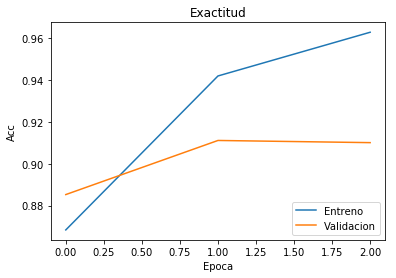

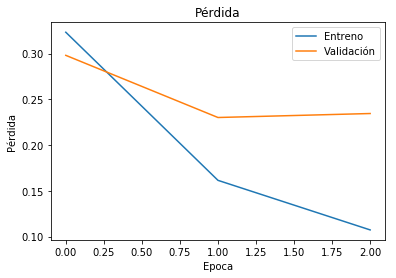

In [11]:
plt.figure(1)
#plt.plot(history.history['accuracy'])
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [12]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [13]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11457  1043]
 [ 1209 11291]]
Exactitud:  0.90992


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [14]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10490  2010]
 [ 2334 10166]]
Exactitud:  0.82624


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [27]:
from keras.layers import LSTM, GRU, Embedding, Dense

In [31]:
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

model_RNN_2 = Sequential()  

model_RNN_2.add(Embedding(input_dim=max_features,output_dim = 128))  
model_RNN_2.add(LSTM(64, activation='sigmoid',return_sequences=True, kernel_initializer=initnorm, bias_initializer='zeros'))  
model_RNN_2.add(LSTM(32, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
model_RNN_2.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

config_transF = model_RNN_2.get_config()

model_RNN_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,621,857
Trainable params: 2,621,857
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_RNN_2 = Sequential.from_config(config_transF)
    model_RNN_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_RNN_2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('RNN_Ex1_part='+str(r)+'.h5')
        model_RNN_2.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 541s 43ms/step - loss: 0.6746 - acc: 0.5524 - val_loss: 0.5199 - val_acc: 0.7760
Epoch 2/3
12500/12500 [==============================] - 516s 41ms/step - loss: 0.3984 - acc: 0.8349 - val_loss: 0.3708 - val_acc: 0.8473
Epoch 3/3
12500/12500 [==============================] - 516s 41ms/step - loss: 0.2370 - acc: 0.9139 - val_loss: 0.3687 - val_acc: 0.8612
Desempeño (exactitud): accu_v1=0.9406399999809265 , accu_v2=0.8538
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 290s 23ms/step - loss: 0.6378 - acc: 0.6106 - val_loss: 0.5475 - val_acc: 0.7373
Epoch 2/3
12500/12500 [==============================] - 289s 23ms/step - loss: 0.3803 - acc: 0.8371 - val_loss: 0.3958 - val_acc: 0.8350
Epoch 3/3
12500/12500 [==============================] - 250s 20ms/step - loss: 0.2089 - acc: 0.9238 - val_loss: 0.4623 - val_acc: 0.8296
Desem

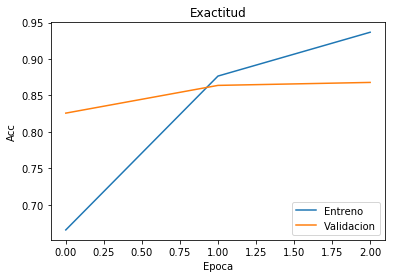

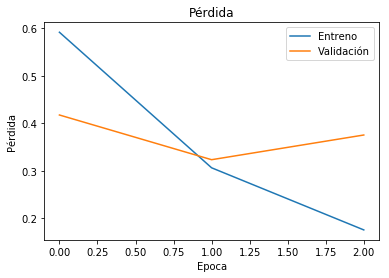

In [33]:
plt.figure(1)
#plt.plot(history.history['accuracy'])
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Podemos observar que manejando una RNN uni-direccional, obtenemos peores resultados tanto en accuracy como en la función de pérdida en comparación con la RNN bi-direccional. Si vemos con detalle los resultados de accuraccy para la muestra de validación podemos observar que en la red bi-direccional obtenemos un accuracy entre 0.88 y 0.91 mientras que para la red uni-direccional tenemos un accuracy a 0.85. Por otro lado, la función de pérdida podemos ver que para la muestra de validación en la red bi-direccional logra minimizarse hasta 0.25, mientras que en la uni-direccional es de 0.35 aproximadamente. Esto se presenta porque las redes neuronales recurrentes tienen la limitación de ejecutar los inputs en un estricto orden, mientras que en la red bi-direccional duplica el proceso al recorrer los inputs en el orden en una primera instancia y luego los vuelven a procesar como si fueran una copia inversa de la secuencia original. Esto permite darle un context más profundo y por lo tanto se obtienen mejores resultados en el aprendizaje.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

In [58]:
from keras.layers import Bidirectional, Dropout, Conv1D, MaxPooling1D
import tensorflow as tf

In [64]:
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

model_RNN_3 = Sequential()  

model_RNN_3.add(Embedding(input_dim=max_features,output_dim = 128))  
model_RNN_3.add(Conv1D(32, 5, activation='sigmoid'))
model_RNN_3.add(MaxPooling1D(pool_size=3))
model_RNN_3.add((LSTM(64, activation='sigmoid',return_sequences=True, kernel_initializer=initnorm, bias_initializer='zeros'))) 
model_RNN_3.add(Dropout(0.3))
model_RNN_3.add((GRU(32, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))) 
model_RNN_3.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 

config_transF3 = model_RNN_3.get_config()

model_RNN_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          20512     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, None, 64)          24832     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total para

In [65]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_RNN_3 = Sequential.from_config(config_transF3)
    model_RNN_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model_RNN_3.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('RNN_Ex2_part='+str(r)+'.h5')
        model_RNN_3.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 183s 15ms/step - loss: 0.6939 - acc: 0.4989 - val_loss: 0.6935 - val_acc: 0.5031
Epoch 2/3
12500/12500 [==============================] - 126s 10ms/step - loss: 0.5718 - acc: 0.6878 - val_loss: 0.4323 - val_acc: 0.8158
Epoch 3/3
12500/12500 [==============================] - 155s 12ms/step - loss: 0.3064 - acc: 0.8809 - val_loss: 0.3475 - val_acc: 0.8606
Desempeño (exactitud): accu_v1=0.9406399999809265 , accu_v2=0.8538
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 213s 17ms/step - loss: 0.6813 - acc: 0.5381 - val_loss: 0.5749 - val_acc: 0.7225
Epoch 2/3
12500/12500 [==============================] - 203s 16ms/step - loss: 0.4212 - acc: 0.8184 - val_loss: 0.3788 - val_acc: 0.8370
Epoch 3/3
12500/12500 [==============================] - 203s 16ms/step - loss: 0.2125 - acc: 0.9251 - val_loss: 0.3982 - val_acc: 0.8465
Desem

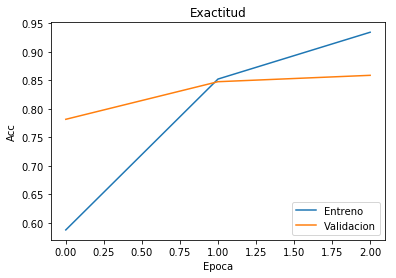

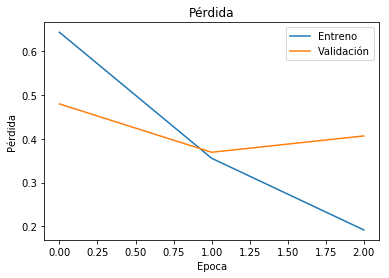

In [66]:
plt.figure(1)
#plt.plot(history.history['accuracy'])
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_acc'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Agregamos una capa convolucional, un dropout para lograr una mejor generalización del modelo y adicionalmente probamos que una de las capas recurrentes fuera GRU. Podemos observar que en los datos de validación obtenemos una mejor generalización de las clasificaciones. Sin embargo, una estrategia para lograr un mejor desempeño en el modelo sería mantener las capas bidireccionales de las capas recurrentes.